In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
# Parameters
Lx = 1.0  # Length of the domain in x-direction
Ly = 1.0  # Length of the domain in y-direction
nu = 0.01  # Viscosity

# Create the neural network model
def create_model():
    inputs = tf.keras.Input(shape=(2,))
    x = layers.Dense(20, activation='tanh')(inputs)
    x = layers.Dense(20, activation='tanh')(x)
    x = layers.Dense(20, activation='tanh')(x)
    outputs = layers.Dense(3)(x)  # u, v, p
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()

# Define the PDE residual
def compute_pde_residual(xy):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xy)
        up = model(xy)
        u, v, p = up[:, 0], up[:, 1], up[:, 2]
        
        # First derivatives
        u_x = tape.gradient(u, xy)[:, 0]
        u_y = tape.gradient(u, xy)[:, 1]
        v_x = tape.gradient(v, xy)[:, 0]
        v_y = tape.gradient(v, xy)[:, 1]
        p_x = tape.gradient(p, xy)[:, 0]
        p_y = tape.gradient(p, xy)[:, 1]
        
        # Second derivatives
        u_xx = tape.gradient(u_x, xy)[:, 0]
        u_yy = tape.gradient(u_y, xy)[:, 1]
        v_xx = tape.gradient(v_x, xy)[:, 0]
        v_yy = tape.gradient(v_y, xy)[:, 1]
    
    # Continuity equation
    continuity = u_x + v_y
    
    # Momentum equations
    momentum_x = u*u_x + v*u_y + p_x - nu*(u_xx + u_yy)
    momentum_y = u*v_x + v*v_y + p_y - nu*(v_xx + v_yy)
    
    del tape
    
    return continuity, momentum_x, momentum_y

# Boundary conditions
def boundary_conditions(xy):
    up = model(xy)
    u, v, p = up[:, 0], up[:, 1], up[:, 2]
    bc_loss = tf.reduce_mean(tf.square(u)) + tf.reduce_mean(tf.square(v))
    return bc_loss

# Training data
def generate_data(num_points):
    x = np.random.uniform(0, Lx, num_points)
    y = np.random.uniform(0, Ly, num_points)
    xy = np.stack([x, y], axis=-1)
    return tf.convert_to_tensor(xy, dtype=tf.float32)

# Loss function
def loss_function(xy):
    continuity, momentum_x, momentum_y = compute_pde_residual(xy)
    pde_loss = tf.reduce_mean(tf.square(continuity)) + \
               tf.reduce_mean(tf.square(momentum_x)) + \
               tf.reduce_mean(tf.square(momentum_y))
    bc_loss = boundary_conditions(xy)
    total_loss = pde_loss + bc_loss
    return total_loss

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
num_epochs = 10000
num_points = 1000

for epoch in range(num_epochs):
    xy = generate_data(num_points)
    with tf.GradientTape() as tape:
        loss = loss_function(xy)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

print("Training completed.")

Epoch 0, Loss: 2.286740779876709
Epoch 100, Loss: 0.008005904033780098
Epoch 200, Loss: 0.001892479369416833
Epoch 300, Loss: 0.00047765401541255414
Epoch 400, Loss: 0.0002846536226570606
Epoch 500, Loss: 0.00022269878536462784
Epoch 600, Loss: 0.00019653802155517042
Epoch 700, Loss: 0.00016597224748693407
Epoch 800, Loss: 0.0001622378476895392
Epoch 900, Loss: 0.00015481389709748328
Epoch 1000, Loss: 0.00013061173376627266
Epoch 1100, Loss: 0.00013257547107059509
Epoch 1200, Loss: 0.00011766445095418021
Epoch 1300, Loss: 0.00010427702363813296
Epoch 1400, Loss: 9.974089334718883e-05
Epoch 1500, Loss: 9.330928151030093e-05
Epoch 1600, Loss: 8.388570131501183e-05
Epoch 1700, Loss: 7.835398719180375e-05
Epoch 1800, Loss: 7.509240822400898e-05
Epoch 1900, Loss: 6.389120244421065e-05
Epoch 2000, Loss: 5.9909314586548135e-05
Epoch 2100, Loss: 5.851351670571603e-05
Epoch 2200, Loss: 5.216427962295711e-05
Epoch 2300, Loss: 4.368749796412885e-05
Epoch 2400, Loss: 3.9161848690127954e-05
Epoch 2

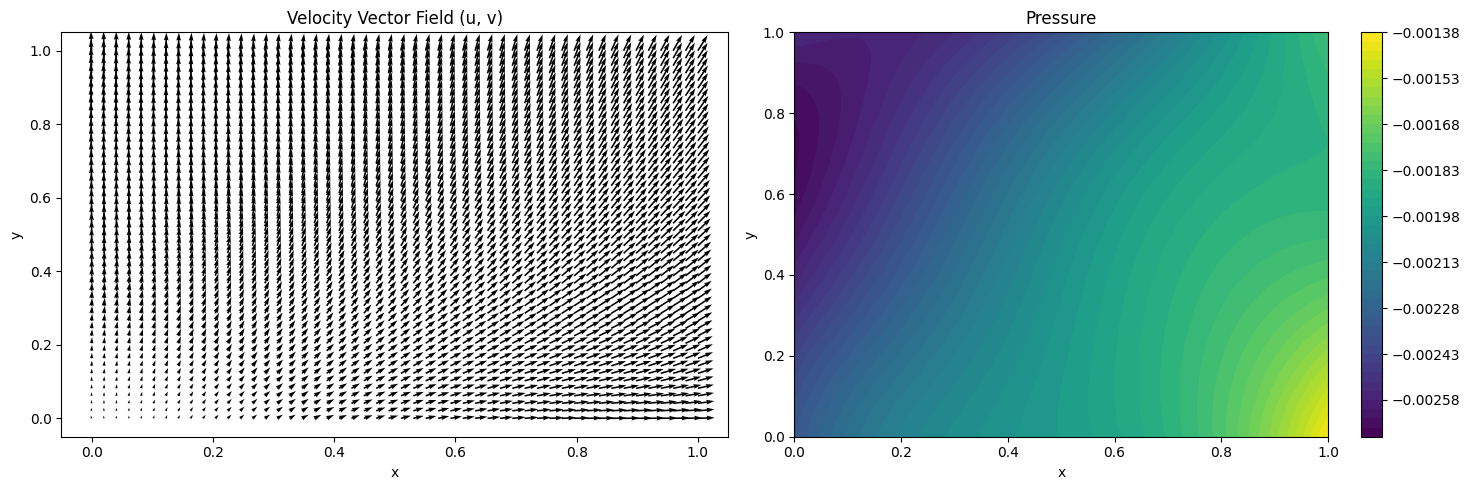

In [10]:
# Visualization
# Generate a grid over the domain
nx, ny = 50, 50
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)
XY = np.stack([X.flatten(), Y.flatten()], axis=-1)
XY_tensor = tf.convert_to_tensor(XY, dtype=tf.float32)

# Predict using the trained model
predictions = model(XY_tensor).numpy()
U = predictions[:, 0].reshape((ny, nx))
V = predictions[:, 1].reshape((ny, nx))
P = predictions[:, 2].reshape((ny, nx))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Velocity vector field
axs[0].quiver(X, Y, U, V, scale=.1, scale_units='xy')
axs[0].set_title('Velocity Vector Field (u, v)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Pressure
c3 = axs[1].contourf(X, Y, P, levels=50, cmap='viridis')
axs[1].set_title('Pressure')
fig.colorbar(c3, ax=axs[1])
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()